## Importing necessary libraries

In [21]:
pip install tensorflow

In [22]:
import numpy as np # xử lý mảng đa chiều (ma trận)
import pandas as pd # xử lý dữ liệu dạng bảng
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 # xử lý ảnh, video: đọc, resize, làm mờ ... ảnh
import os

### Extracting files from zip

In [23]:
import zipfile
archieve = zipfile.ZipFile('Fall.zip')
archieve.extractall()

## Reading train labels

In [24]:
df_train = pd.read_csv('Fall/train_labels.csv', index_col='images')
df_train

,labels
images,
fall-02-cam1-rgb-001.jpg,0
fall-02-cam1-rgb-002.jpg,0
fall-02-cam1-rgb-003.jpg,0
fall-02-cam1-rgb-004.jpg,0
fall-02-cam1-rgb-005.jpg,0
...,...
fall-09-cam1-rgb-181.jpg,1
fall-09-cam1-rgb-182.jpg,1
fall-09-cam1-rgb-183.jpg,1


## Reading test labels

In [25]:
test_df = pd.read_csv('Fall/test_labels.csv', index_col='images')
test_df

,labels
images,
fall-03-cam1-rgb-077.jpg,0
fall-03-cam1-rgb-093.jpg,0
fall-03-cam1-rgb-178.jpg,1
fall-03-cam1-rgb-196.jpg,1
fall-04-cam1-rgb-005.jpg,0
fall-04-cam1-rgb-042.jpg,1
fall-04-cam1-rgb-057.jpg,1
fall-17-cam1-rgb-068.jpg,1
fall-17-cam1-rgb-094.jpg,1


In [26]:
# reading train and test images from the folder and stacking them while keep tracking of corresponding labels
dataset_folder = 'Fall'

#Khởi tạo danh sách trống
train_images = []
train_labels = []
test_images = []
test_labels = []

for folder in os.listdir(dataset_folder):  # lặp qua tất cả cac thư mục trong "Fall"
    folder_path = os.path.join(dataset_folder, folder)
    if folder == 'train_images':  # đọc ảnh huấn luyện
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)  # mở từng ảnh trong folder train_images
                train_images.append(img)
                train_labels.append(df_train.loc[file, 'labels'])  # lấy nhãn từ df_train
    elif folder == 'test_images': # đọc ảnh test
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                test_images.append(img)
                test_labels.append(test_df.loc[file, 'labels'])
    else:
        pass

# chuyển danh sách sang dạng mảng numpy (để sử dụng trong tensorflow)
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# in kích thước dữ liệu
print('Shape of stacked train images:', train_images.shape)
print('Shape of train labels:', train_labels.shape)
print('Shape of stacked test images:', test_images.shape)
print('Shape of test labels:', test_labels.shape)

Shape of stacked train images: (405, 96, 96, 3)
Shape of train labels: (405,)
Shape of stacked test images: (17, 96, 96, 3)
Shape of test labels: (17,)


## Visualizing some images together with their label to have an idea about our data

In [27]:
# Function to convert binary label into text
def get_label(num):
    if num == 0:
        return 'NOT FALL'
    if num == 1:
        return 'FALL'
    else:
        return -1

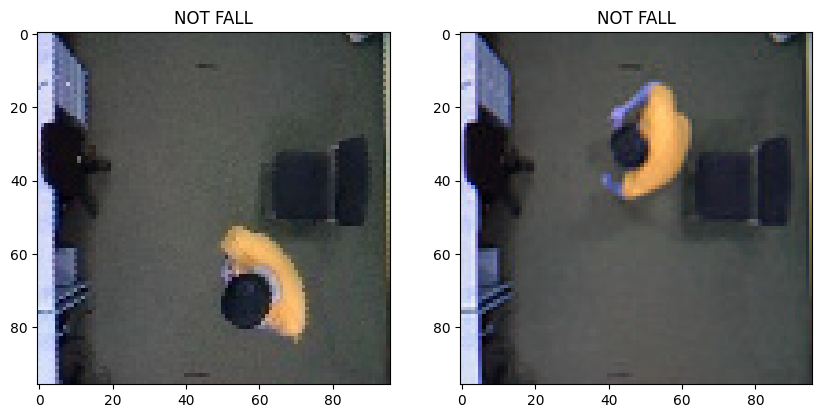

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), squeeze=False)
axes[0][0].imshow(train_images[2])
axes[0][0].set_title(get_label(train_labels[2]))

axes[0][1].imshow(train_images[10])
axes[0][1].set_title(get_label(train_labels[10]));

## Splitting our data into train and validation sets, building and training our model

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2)

In [30]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2

# FallNet architecture
model_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), name='inputs')

conv1 = Conv2D(16, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name='convolution_1')(model_input)
pool1 = MaxPooling2D(pool_size=(2, 2), name='pooling_1')(conv1)

conv2 = Conv2D(16, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name='convolution_2')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), name='pooling_2')(conv2)

conv3 = Conv2D(32, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name='convolution_3')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2), name='pooling_3')(conv3)

conv4 = Conv2D(32, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name='convolution_4')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2), name='pooling_4')(conv4)

conv5 = Conv2D(64, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name='convolution_5')(pool4)
pool5 = MaxPooling2D(pool_size=(2, 2), name='pooling_5')(conv5)

conv6 = Conv2D(64, (3, 3), padding='same', activation='relu',kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name='convolution_6')(pool5)
pool6 = MaxPooling2D(pool_size=(2, 2), name='pooling_6')(conv6)

flat = Flatten(name='flatten')(pool6)
dense1 = Dense(32, activation='relu', name='dense1')(flat)
output = Dense(1, activation='sigmoid', name='output')(dense1)

model = Model(inputs=[model_input], outputs=[output])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_1 (Conv2D)          │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_1 (MaxPooling2D)        │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_2 (Conv2D)          │ (None, 48, 48, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_2 (MaxPooling2D)        │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_3 (Conv2D)          │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_3 (MaxPooling2D)        │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_4 (Conv2D)          │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_4 (MaxPooling2D)        │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_5 (Conv2D)          │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_5 (MaxPooling2D)        │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_6 (Conv2D)          │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_6 (MaxPooling2D)        │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,193 (289.82 KB)

 Trainable params: 74,193 (289.82 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
!pip install tensorflow-model-optimization


In [32]:
!pip install visualkeras

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


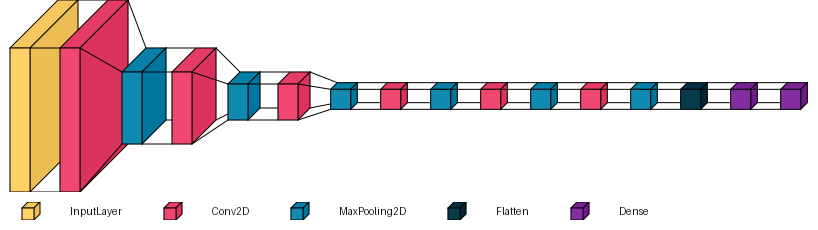

In [33]:
import visualkeras
from PIL import ImageFont

font = ImageFont.load_default()

visualkeras.layered_view(
    model,
    legend=True,
    font=font,
    to_file='fallnet_architecture_block.png',
    scale_xy=1.5,  # Điều chỉnh tỉ lệ trục X, Y để rõ hơn
    spacing=30,     # Khoảng cách giữa các layer
    draw_volume=True  # Hiển thị kích thước đầu ra của mỗi layer
)


### Visualizing out CNN Arhitecture with visualkeras Library

In [65]:
import tensorflow as tf

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 550ms/step - accuracy: 1.0000 - loss: 3.7354e-08 - val_accuracy: 1.0000 - val_loss: 3.1467e-08
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - accuracy: 1.0000 - loss: 3.7214e-08 - val_accuracy: 1.0000 - val_loss: 1.2033e-11
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 1.0000 - loss: 6.3794e-07 - val_accuracy: 1.0000 - val_loss: 1.5229e-17
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.9948 - loss: 0.0683 - val_accuracy: 1.0000 - val_loss: 5.4704e-10
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.9692 - loss: 0.3100 - val_accuracy: 0.6790 - val_loss: 3.1993
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.8770 - loss: 1.0007 - val_accuracy: 1.0000 - val_loss: 7.0282e-04
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.9699 - loss: 0.0736 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.9919 

## Accuracy/Loss vs Epochs

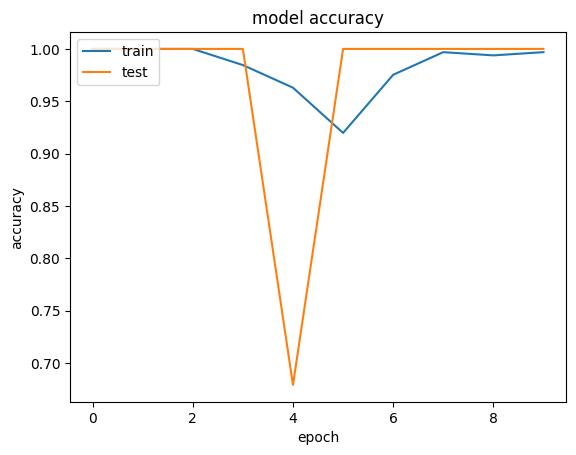

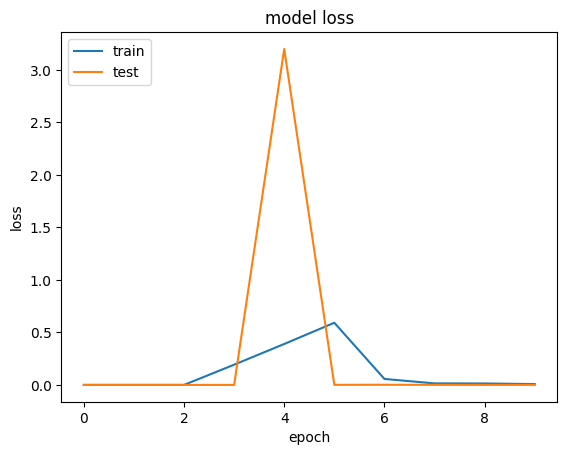

Weights saved.


In [66]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('model.h5')
print('Weights saved.')

## Testing our model

In [67]:
predicted_labels = (model.predict(test_images) >= 0.5).astype('int64').flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inputs']
Received: inputs=Tensor(shape=(17, 96, 96, 3))
  warnings.warn(msg)


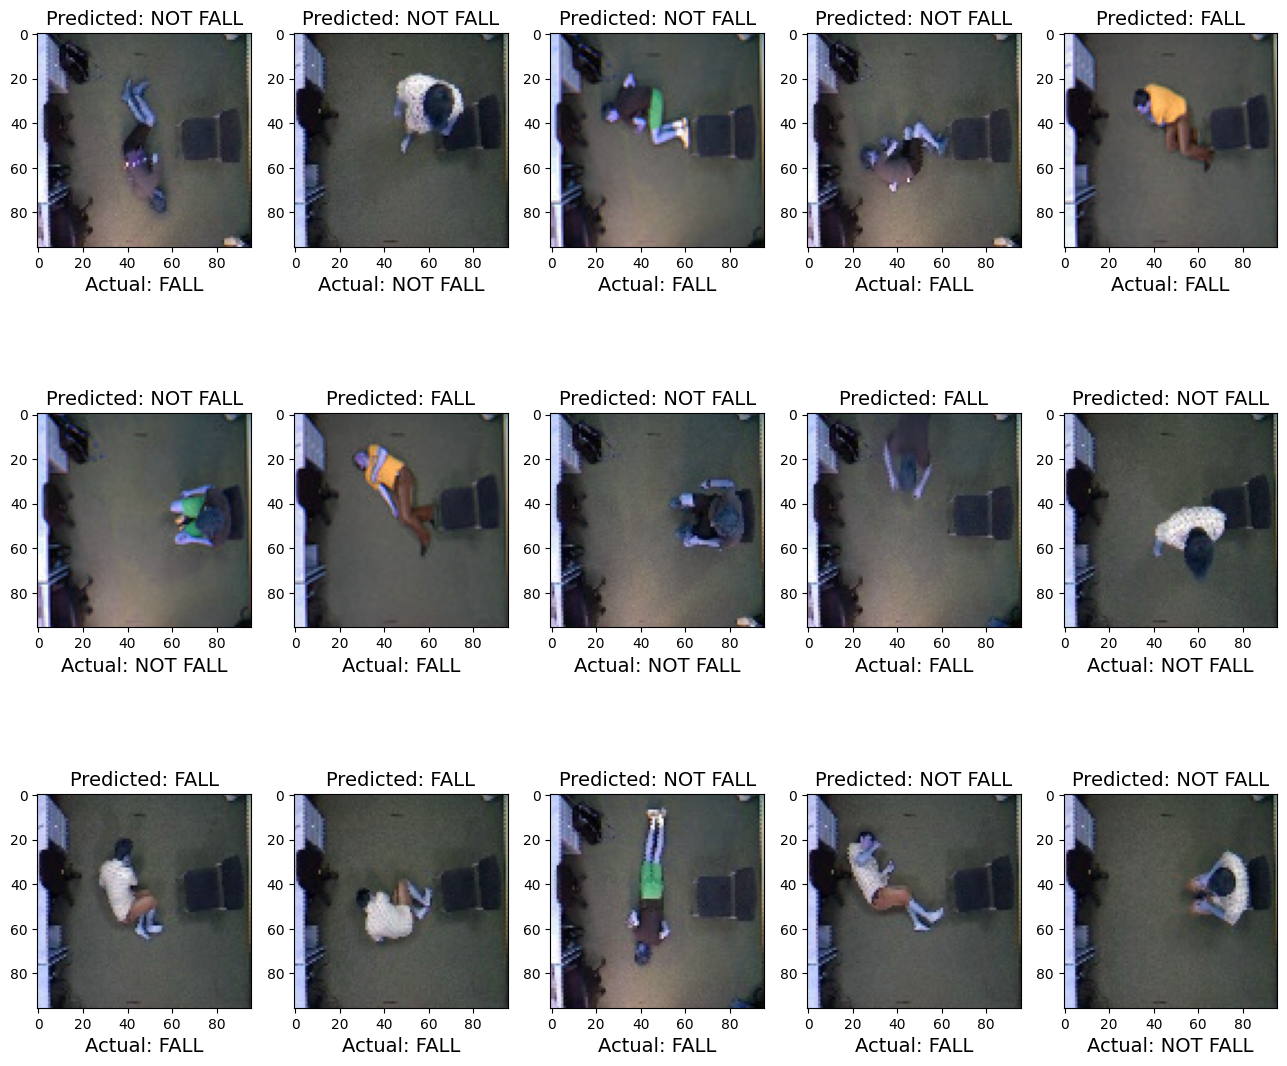

In [68]:
# visualizing our results
row = 3
col = 5
fig, axes = plt.subplots(row, col, figsize=(16, 14))
c = 0
for i in range(row):
    for j in range(col):
        axes[i][j].imshow(test_images[c])
        axes[i][j].set_title(f'Predicted: {get_label(predicted_labels[c])}', fontsize=14)
        axes[i][j].set_xlabel(f'Actual: {get_label(test_labels[c])}', fontsize=14)
        c += 1

In [69]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

IMG_SIZE = (96, 96, 3)  # đổi theo model
image_dir = "Fall/test_images"
csv_path = "Fall/test_labels.csv"

# Đọc file CSV
df = pd.read_csv(csv_path)

# Đọc ảnh và nhãn
images = []
labels = []

for index, row in df.iterrows():
    img_path = os.path.join(image_dir, row['images'])

    if os.path.exists(img_path):
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0  # normalize
        images.append(img_array)
        labels.append(row['labels'])
    else:
        print(f"⚠️ File not found: {img_path}")

# Chuyển sang array
x_test = np.array(images)
y_test = np.array(labels)

# Kiểm tra shape
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)


x_test: (17, 96, 96, 3)
y_test: (17,)


In [70]:
float_loss, float_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Float model accuracy:     {float_acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['inputs']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)


Float model accuracy:     64.71%
